# Experimtal validation of Proposition B.1

In [1]:
import matplotlib.pyplot as plt
from sympy import init_printing
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import numpy as np
import torch
import random
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

/rlhf-dev/filtered-dpo/.venv/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/rlhf-dev/filtered-dpo/.venv/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/rlhf-dev/filtered-dpo/.venv/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


## Preparation
### load GPT-2 model and tokenizer

In [2]:
# Load GPT-2 model and tokenizer
# model_name = "gpt2"
model_name = "gpt2-large"
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
print("Model loaded", model)

Model loaded GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1280)
    (wpe): Embedding(1024, 1280)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-35): 36 x GPT2Block(
        (ln_1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1280, out_features=50257, bias=False)
)


### define utility functions

In [5]:
###
# Calculate log probabilities and gradients
def get_log_probs_and_gradients(input_ids, prompt_size):
    # Forward pass
    outputs = model(input_ids, labels=input_ids)
    logits = outputs.logits[:, :-1, :]  # Shifted to predict next token
    labels = input_ids[:, 1:]  # Shift labels to match logits for the next token

    # Log-softmax for log probabilities
    log_probs = torch.nn.functional.log_softmax(logits, dim=-1)

    # Gather the log probabilities of the actual next tokens (labels)
    token_log_probs = log_probs.gather(2, labels.unsqueeze(-1)).squeeze(-1)

    # Exclude the prompt tokens from the log probability calculation
    token_log_probs = token_log_probs[:, prompt_size:]  # Ignore the first prompt_size tokens

    # Sum the log probabilities for the entire sequence
    total_log_prob = token_log_probs.sum()

    # Backward pass for gradients
    model.zero_grad()  # Reset gradients
    total_log_prob.backward()  # Compute gradients
    # gradients = {name: param.grad for name, param in model.named_parameters() if param.grad is not None}
    # Convert gradients to vectors (flattened tensors)
    gradients = {name: param.grad.view(-1) for name, param in model.named_parameters() if param.grad is not None}

    # Concatenate all gradient vectors into a single vector
    gradients = torch.cat([grad for grad in gradients.values()])

    return total_log_prob.cpu().item(), gradients.detach().cpu().numpy()


# Set random seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

## Experiment
### generate samples and calculate log probabilities and gradients

In [9]:
# Init parameter
n_samples = 16
max_length = 64
seed = 0

# Set the seed to a specific value
set_seed(seed)

# Generate sentences, calculate log probabilities, and store model's gradients
generated_texts = []
log_probs = []
input_prompt = "Let's talk about"
# input_prompt = "Please have a conversation with me about"
# input_prompt = "Could you please"
# input_prompt = "I am a"

for i in tqdm(range(n_samples)):
    input_ids = tokenizer.encode(input_prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(
        input_ids, max_length=max_length, do_sample=True, top_p=0.9, pad_token_id=tokenizer.eos_token_id
    )
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    generated_texts.append(generated_text)

    # Calculate log probs and model parameter gradients
    log_prob, gradients = get_log_probs_and_gradients(outputs, prompt_size=input_ids[0].shape[0])
    log_probs.append(log_prob)
    np.save(f"npy/{model_name}_gradients_{i}.npy", gradients)
    del gradients
    torch.cuda.empty_cache()

for i, generated_text in enumerate(generated_texts):
    print(f"Text {i}: {generated_text}")

100%|██████████| 16/16 [05:11<00:00, 19.48s/it]

Text 0: Let's talk about the most recent one: The "We Can't Stop" campaign.

It is a very specific, yet very powerful, type of anti-gun sentiment that was brought to us by an individual named Dan Schoen, and we've seen its influence in all of our media coverage.


Text 1: Let's talk about that, and I hope you guys will be back. This was an hour long podcast that I had a blast recording, and I want to give a huge thanks to all the listeners for being here.


First things first, I wanted to give a big thanks to all the listeners. I appreciate
Text 2: Let's talk about this again. What does it mean to "go native?"

The answer is pretty much the same as it always was:

Your design is your responsibility, and it is your responsibility to figure out what that design is doing and how it is affecting your users.

But with native
Text 3: Let's talk about the most common problem: an unresponsive application. The first thing I would do when I found the issue was to stop the application. Here is th

### calculate inner products and cosine similarities between gradients of different texts

In [10]:
cos_sims = []
log_deltas = []
log_norm_ratios = []

for i in range(n_samples):
    # print(f"text {i}: {generated_texts[i]}")
    gradient_i = np.load(f"npy/{model_name}_gradients_" + str(i) + ".npy")
    norm_i = np.linalg.norm(gradient_i)
    for j in range(i+1 , n_samples):
        gradient_j = np.load(f"npy/{model_name}_gradients_" + str(j) + ".npy")
        # inner product
        inner_product = np.dot(gradient_i, gradient_j)
        
        # norm of gradients
        norm_j = np.linalg.norm(gradient_j)
        
        # log norm_i / norm_j
        log_norm_ratio = np.log(norm_i / norm_j) 
        
        # cos similarity
        cosine_similarity = inner_product / (norm_i * norm_j)
        
        # log delta = log (p_i / p_j) 
        log_delta = log_probs[i] - log_probs[j]

        # Store the results
        cos_sims.append(cosine_similarity)
        log_deltas.append(log_delta)
        log_norm_ratios.append(log_norm_ratio)
        
        # Print the results
        print(f"=== index {i} vs {j} ===")
        print(f"log delta: {log_delta}")
        print(f"Norm ratio: {log_norm_ratio}")
        print(f"Cosine similarity: {cosine_similarity}")

=== index 0 vs 1 ===
log delta: -34.63453674316406
Norm ratio: -0.04096949100494385
Cosine similarity: 0.010436630807816982
=== index 0 vs 2 ===
log delta: -39.711326599121094
Norm ratio: 0.060503438115119934
Cosine similarity: 0.06374682486057281
=== index 0 vs 3 ===
log delta: -28.649139404296875
Norm ratio: 0.012578791938722134
Cosine similarity: 0.03294891491532326
=== index 0 vs 4 ===
log delta: -30.735992431640625
Norm ratio: 0.012080834247171879
Cosine similarity: 0.05845014378428459
=== index 0 vs 5 ===
log delta: -31.09703826904297
Norm ratio: 0.013283329084515572
Cosine similarity: 0.018960298970341682


=== index 0 vs 6 ===
log delta: -16.898239135742188
Norm ratio: -0.08847668766975403
Cosine similarity: 0.005629478022456169
=== index 0 vs 7 ===
log delta: -18.699554443359375
Norm ratio: 0.08078710734844208
Cosine similarity: 0.05208093300461769
=== index 0 vs 8 ===
log delta: -26.00146484375
Norm ratio: 0.00750507740303874
Cosine similarity: 0.03859593719244003
=== index 0 vs 9 ===
log delta: -29.740211486816406
Norm ratio: -0.14447851479053497
Cosine similarity: 0.03536652401089668
=== index 0 vs 10 ===
log delta: -8.344818115234375
Norm ratio: -0.06497731059789658
Cosine similarity: 0.04654870182275772
=== index 0 vs 11 ===
log delta: -34.10285186767578
Norm ratio: -0.005609959829598665
Cosine similarity: 0.046435896307229996
=== index 0 vs 12 ===
log delta: -30.98180389404297
Norm ratio: -0.02521050162613392
Cosine similarity: 0.04969289153814316
=== index 0 vs 13 ===
log delta: -42.327232360839844
Norm ratio: 0.15785320103168488
Cosine similarity: 0.040324755012989044
=== index 

### plot the results

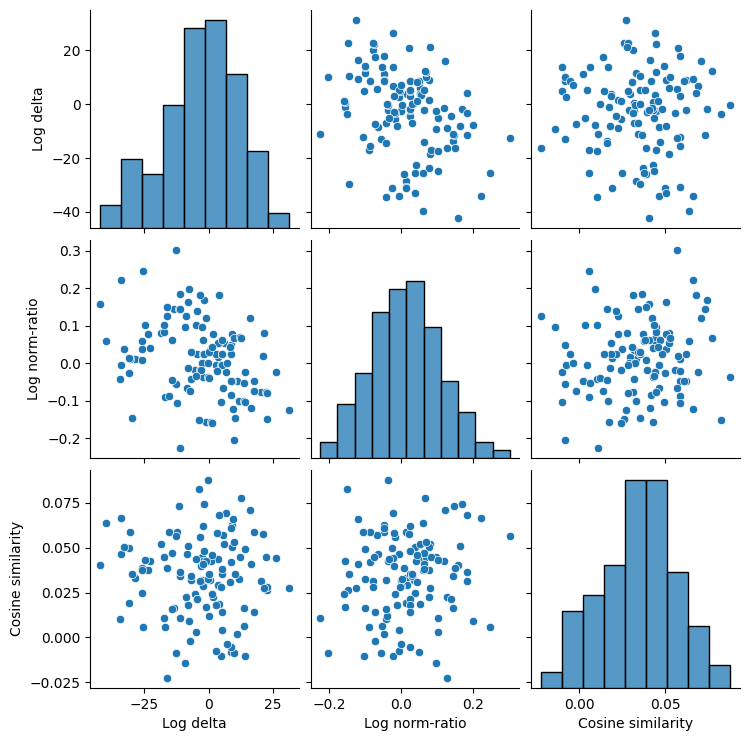

Prompt: Let's talk about
Correlation matrix


,Log delta,Log norm-ratio,Cosine similarity
Log delta,1.000000,-0.332567,-0.035197
Log norm-ratio,-0.332567,1.000000,0.113806
Cosine similarity,-0.035197,0.113806,1.000000


In [11]:
# Data frame creation
data = pd.DataFrame({"Log delta": log_deltas, "Log norm-ratio": log_norm_ratios, "Cosine similarity": cos_sims})

# Create a scatter plot of all pairs
sns.pairplot(data)

# Adjust the font size
plt.rcParams["font.size"] = 12

# Save as a PDF file
# plt.savefig(f'fdpo-prop-{input_prompt}.pdf')

# Display the plot
plt.show()

# etc.
print(f"Prompt: {input_prompt}")
print("Correlation matrix")
data.corr()